In [1]:
import os
import zipfile
import numpy as np
import pandas as pd



def radarParamsFormat():
    # pd.DataFrame(
    #     {
    #         'variable_names':,
    #         'variable_lengths':,
    #         'variable_type':,
    #     }
    # )
#     tmpdir = os.path.dirname(os.path.realpath(__file__))
    return pd.read_csv('radarFormat.csv', encoding='gbk')


def readSingleCanZip(filein, read_parameters, radar_parameters_format=radarParamsFormat()):
    pass
    '''
    filein  输入文件
    read_parameters 需要读取的雷达参数
    ----
    输出字典
    ---------
    当读取dbz等数据的时候需要首先读取基本的雷达参数，这里简化不做判断
    '''

    # 定义一些必备参数,无论在读取参数中是否设定，都会读取必备参数
    data_parameters_name = ['timeAzimuth', 'elevationData',
                            'azimuthData', 'reflectData', 'velData', 'widData']
    essential_parameters_name = ['radarNO', 'radarName', 'longitude',
                                 'latitude', 'altitude', 'AZNum', 'ELNums', 'reflectDist']

    # 将必备的一些参入加入到读取参数中
    for ipa, vpa in enumerate(essential_parameters_name):
        if vpa not in read_parameters:
            read_parameters.append(vpa)

    # 判断文件是否存在
    if os.path.exists(filein):
        print('Right now read the single radar can.zip : {}'.format(
            os.path.split(filein)[-1]))
        outData = {}
        with zipfile.ZipFile(filein, 'r') as zf:
            zipdata = zf.read(zf.namelist()[0])
            # print(zipdata.dtype)
        # 开始循环需要读取的参数
        radar_parameters_name = radar_parameters_format['radarParas'].tolist(
        )
        radar_parameters_type = radar_parameters_format['parasType'].tolist(
        )
        radar_parameters_length = radar_parameters_format['paraslength'].values
        # print(np.frombuffer(zipdata[:50],50))

        # 按照雷达全部参数顺序读取数据
        for ipa, vpa in enumerate(radar_parameters_name):
            # print(ipa, vpa)
            # 如果雷达参数在数据中则开始读取数据
            vpa_index = radar_parameters_name.index(vpa)
            # 读取非头文件数据时，则需要修改具体数据的长度
            if vpa == 'timeAzimuth' or vpa == 'azimuthData':
                radar_parameters_length[vpa_index] = outData['AZNum'] * 4
            elif vpa == 'elevationData':
                radar_parameters_length[vpa_index] = outData['ELNums'] * 4
            elif vpa == 'reflectData' or vpa == 'velData' or vpa == 'widData':
                radar_parameters_length[vpa_index] = outData['reflectObjNum'] * outData['AZNum'] * outData['ELNums'] * 1

            vpa_start_index = np.sum(
                radar_parameters_length[:vpa_index])
            vpa_end_index = radar_parameters_length[:vpa_index + 1].sum()
            if vpa in read_parameters:
                if vpa not in data_parameters_name:
                    outData[vpa] = np.frombuffer(
                        zipdata[vpa_start_index: vpa_end_index], radar_parameters_type[vpa_index])[0]  # [0]
                if vpa == 'timeAzimuth' or vpa == 'azimuthData':
                    outData[vpa] = np.frombuffer(
                        zipdata[vpa_start_index: vpa_end_index], radar_parameters_type[vpa_index]).reshape(
                        outData['AZNum'])
                elif vpa == 'elevationData':
                    outData[vpa] = np.frombuffer(
                        zipdata[vpa_start_index: vpa_end_index], radar_parameters_type[vpa_index]).reshape(
                        outData['ELNums'])
                elif vpa == 'reflectData' or vpa == 'velData' or vpa == 'widData':
                    tmpvpa = np.frombuffer(
                        zipdata[vpa_start_index: vpa_end_index], radar_parameters_type[vpa_index]).reshape(
                        outData['ELNums'], outData['AZNum'], outData['reflectObjNum'])
                    #
                    # elif vpa == 'longitude':
                    #     longitude = np.frombuffer(
                    #         zipdata[vpa_start_index: vpa_end_index], radar_parameters_type[vpa_index])
                    #     print(longitude)
                    # elif vpa == 'latitude':
                    #     latitude = np.frombuffer(
                    #         zipdata[vpa_start_index: vpa_end_index], radar_parameters_type[vpa_index])
                    #     print(latitude)

                    # tmpvpa.flags.writeable=True
                    # print('before------',tmpvpa.shape)  64,238,656
                    # dat= np.concatenate((np.full((tmpvpa.shape[0],tmpvpa.shape[1],20), 125),tmpvpa),axis=2)
                    # dat = np.array(dat,dtype=np.int8)
                    # print('after------',dat.shape)
                    if vpa == 'reflectData':
                        outData[vpa] = np.ma.masked_greater(tmpvpa, 80)  # 80
                    elif vpa == 'velData':
                        outData[vpa] = np.ma.masked_greater(tmpvpa, 100)
                    elif vpa == 'widData':
                        outData[vpa] = np.ma.masked_greater(tmpvpa, 100)

                    # del dat
            else:
                outData[vpa] = None
#         print(outData)
        return outData
    else:
        print("Can't not found the {} in the directory: {}".format(
            *(os.path.split(filein)[::-1])))

In [22]:
import sys
import os
import time
import math
import netCDF4
from numba import jit
import numpy as np
import pandas as pd
from scipy import optimize
from sklearn.metrics import mean_squared_error  as mse


def get_real_ele(slant_range, height_value, elevation):
    '''
        # 通过截距和高度，找到仰角，再通过获得到的仰角，寻找最近的那个高仰角。
    '''
    ele_tmp = np.rad2deg(math.asin(height_value / slant_range))
    argmin = abs(ele_tmp - elevation).argmin()
    # if ele_tmp > elevation[argmin]:
    #    argmin = argmin + 1

    if argmin >= 64:
        argmin = 63
    return argmin


def get_real_r(height_value, real_ele):
    '''
    # 通过得到的仰角和高度，计算截距。
    '''
    real_sinele = np.sin(np.deg2rad(real_ele))
    real_slant = height_value / real_sinele
    # if real_slant > 20000:
    #     print(real_slant,real_ele,height_value,ele_tmp)
    real_r = real_slant // 30
    return real_r


def _sd_to_uv(speed, direction):
    """ Takes speed and direction to create u_mean and v_mean. """
    return (np.sin(np.deg2rad(direction)) * speed), (np.cos(np.deg2rad(direction)) * speed)


def fit(x, a, b, c):
    return a * np.sin(np.deg2rad(x + b)) + c


def find_circle(vel, height_value, azimuth, elevation):
    # 通过截距和高度，找到仰角，再通过获得到的仰角，寻找最近的那个高仰角。
    slant_range = 15000  # 10000   # 截距
    # height_value  = height[i]
    argmin = get_real_ele(slant_range, height_value, elevation)
    # print('argmin', argmin, 'ele', elevation[argmin])
    real_ele = elevation[argmin]

    # 通过得到的仰角和高度，计算截距。
    real_r = get_real_r(height_value, real_ele)
    # real_r = slant_range//30
    # if real_r > 1480:
    #    real_r = get_real_r(height_value,elevation[argmin+1])
    # 得到circle
    # print('real_r', real_r, argmin)
    veldata = vel[argmin, :, int(real_r) - 1]
    vals = np.isnan(veldata) == False
    # print(vals)
    count = np.sum(vals)
    if count >= 25:  # 条件1：有效点数量超25个
        x = azimuth[vals]
        y = veldata[vals]
        
        if height_value == 2200:
            global xx,yy
            xx = x
            yy = y
        # 拟合
        fita, fitb = optimize.curve_fit(fit, x, y)
        # y = a*sin(x+b)+c
        gus = fit(x, fita[0], fita[1], fita[2])
        # 计算rmse
        sin_mse = mse(y, gus)
        sin_rmse = np.sqrt(sin_mse)
        if sin_rmse <= 5 and fita[2] <= 7:  # 条件2：拟合均方根误差小于5m/s   条件3：对称性不超过7     "Symmetry",fita[2]
            if fita[0] > 0:
                direction = 270 - fita[1]
            else:
                direction = 90 - fita[1]
            if direction > 360:
                direction = direction - 360
            elif direction < 0:
                direction = direction + 360
            uwind, vwind = _sd_to_uv(fita[0], direction)
            if fita[0] > 0:
                uwind = -uwind
                vwind = -vwind
            # print(fita[0],'angle',direction,'uwind',uwind,'vwind',vwind)
            # print("ok:",height_value)
            vad_meta = {"height": height_value, "speed": fita[0], "angle": direction, "uwind": uwind, "vwind": vwind}
        else:
            # print("no",height_value)
            vad_meta = {"height": height_value, "speed": np.nan, "angle": np.nan, "uwind": np.nan, "vwind": np.nan}

        # plt.scatter(x,y)
        # plt.plot(np.arange(0,360),fit(np.arange(0,360),fita[0],fita[1],fita[2]))
        # plt.show()
        # return vad_meta
    else:
        # print('no 25 points',height_value)
        vad_meta = {"height": height_value, "speed": np.nan, "angle": np.nan, "uwind": np.nan, "vwind": np.nan}
    # print(vad_meta)
    return vad_meta


def vad_main(filename, radar_id, base_dir, output_dir, z_want=None):
    # read the data
    filein = os.path.join(base_dir, radar_id, filename[:8], '{}_vol.can.zip'.format(filename))
    # filein = r"D:\Python\radar_data\windline\input_57599\input\radar_01\20190826\2019082605280000_vol.can.zip"
    print(filein, os.path.exists(filein))
    if os.path.exists(filein):
        outdir = os.path.join(output_dir, 'pkl', radar_id, filename[:8])
        if not os.path.exists(outdir):
            try:
                os.makedirs(outdir)
                print('We are going to makedirs', outdir)
            except:
                pass
        if filename is None or radar_id is None:
            print('No radar calc --- {}  -- {}'.format(filename, radar_id))

        # radar_fileout = os.path.join(outdir, '{}.nc'.format(filename))
        radar_fileout = os.path.join(outdir, '{}.pkl'.format(filename))

        read_parameters = ['reflectObjNum', 'timeAzimuth', 'elevationData', 'azimuthData', 'reflectData', 'velData',
                           'widData']
        can_zip_data = readSingleCanZip(filein, read_parameters)
        vel = can_zip_data['velData']
        azimuth = can_zip_data['azimuthData']
        # print(len(azimuth))
        elevation = can_zip_data['elevationData']
#         print("velData\n",vel)
#         print("azimuthData\n",azimuth)
#         print('elevationData\n',elevation)
        # print(elevation)
        elevation = 90 / 64 * elevation + 90 / 64 / 2
        # print(elevation)
        if z_want is None:
            z_want = np.arange(100, 10100, 300)
            # z_want = np.arange(100, 15000, 200)

        s_time = time.time()
        allret = []
        for height_value in z_want:
            try:
                vad_meta = find_circle(vel, height_value, azimuth, elevation)
            except:
                vad_meta = {"height": height_value, "speed": np.nan, "angle": np.nan, "uwind": np.nan, "vwind": np.nan}
            # if vad_meta['speed'] is None:
            #    continue
            allret.append(vad_meta)
        vad = pd.DataFrame(allret)
        # vadshape = vad.shape
        # print("--------")
        # print(vadshape)
        # print(vad)
        # if vadshape[0]==0 and vadshape[1]==0:
        #    return "no height"
        # print(vad['height'],'speed',vad['speed'],'direction',vad['angle'],'uwind',vad['uwind'],'vwind',vad['vwind'])

        # saveNetcdf(vad['height'], vad['speed'], vad['angle'], vad['uwind'], vad['vwind'], filename, radar_fileout)
        vad.to_pickle(radar_fileout)
#         print(vad)
        print('=====Saved pklfile dataset to file :', radar_fileout)
        e_time = time.time()
        return "end time: {}".format(e_time - s_time)
    else:
        return 'data is not exists'


def saveNetcdf(height, speed, direction, u_wind, v_wind, filename, outdir=r'D:\radarData\products\cappi\single_radar'):
    '''
    create dataset
    '''
    fileout = os.path.join(outdir)
    # print('Save file to ', fileout)
    if os.path.exists(fileout):
        os.remove(fileout)

    ncfile = netCDF4.Dataset(fileout, 'w', format='NETCDF4_CLASSIC')
    z_dim = ncfile.createDimension('height', height.size)

    z_data = ncfile.createVariable('height', np.float32, ('height',))
    z_data[:] = height.tolist()

    speed_data = ncfile.createVariable('speed', np.float32, ('height',), fill_value=125, zlib=True, complevel=4)
    direction_data = ncfile.createVariable('direction', np.float32, ('height',), fill_value=125, zlib=True, complevel=4)
    uwind_data = ncfile.createVariable('uwind', np.float32, ('height',), fill_value=125, zlib=True, complevel=4)
    vwind_data = ncfile.createVariable('vwind', np.float32, ('height',), fill_value=125, zlib=True, complevel=4)

    speed_data[:] = speed.tolist()  # [np.newaxis, :,:,:]  'time'
    direction_data[:] = direction.tolist()
    uwind_data[:] = u_wind.tolist()
    vwind_data[:] = v_wind.tolist()

    # close the file object
    ncfile.close()
    print('=====Saved netcdf dataset to file :', fileout)

    
# base_dir = r"D:\Python\radar_data\windline\vwp\input_data"
# output_dir = r"D:\Python\radar_data\windline\vwp"
# radar_id = 'radar_01'
# filename = "2019082605280000"

# vad_main(filename, radar_id, base_dir, output_dir)

D:\Python\radar_data\windline\vwp\input_data\radar_01\20190826\2019082605280000_vol.can.zip True
Right now read the single radar can.zip : 2019082605280000_vol.can.zip
         angle  height      speed      uwind      vwind
0   189.086748     100   2.730648   0.431250   2.696379
1          NaN     400        NaN        NaN        NaN
2   240.457176     700   9.959000   8.664205   4.910523
3   214.186154    1000  10.227711   5.746782   8.460530
4   220.732688    1300  12.610255   8.228580   9.555574
5   228.848993    1600  14.818897  11.158302   9.751514
6   229.638323    1900  16.073664  12.247676  10.409471
7   228.283034    2200  15.346625  11.455353  10.212433
8   228.254243    2500  17.324898  12.926222  11.535374
9   226.716941    2800  16.970407  12.354040  11.634964
10 -141.374318    3100  17.962301  11.212604  14.032881
11 -141.586739    3400  17.786235  11.051106  13.936399
12 -142.557349    3700  18.472937  11.230937  14.666815
13  213.465235    4000  17.752741   9.789410  14

'end time: 0.16401124000549316'

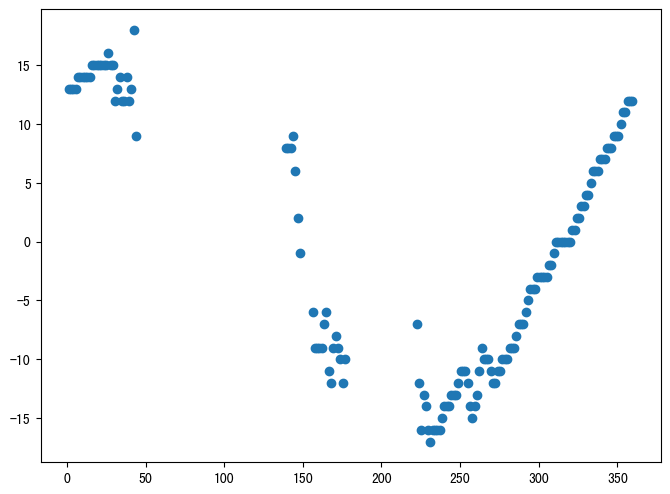

In [19]:
import matplotlib.pyplot as plt
# print(x.shape,y.shape)
# print("*************")
plt.figure(figsize=(8,6),dpi=100)
plt.scatter(xx,yy)
plt.show()

In [27]:
import os, sys
import datetime, time
import numpy as np
import pandas as pd
import netCDF4
import gc
import matplotlib.pyplot as plt


# from Const import dataPath


class DrawVad(object):
    '''
    define all apis
    '''

    def __init__(self, filename, radar_id, output_dir):
        self.filename = filename
        self.radar_id = radar_id
        self.output_dir = output_dir
        self.fill_height = np.arange(100, 10100, 300)
        self.fill_uwind = np.full(shape=self.fill_height.shape, fill_value=np.nan)
        self.fill_vwind = np.full(shape=self.fill_height.shape, fill_value=np.nan)

    def _get_singlefile_exists(self, filename, radar_id, output_dir):
        '''
        check the input filename exists
        '''
        # datadir = os.path.dirname(os.path.dirname(base_dir))

        filein = os.path.join(
            output_dir, 'pkl', radar_id, filename[:8], '{}.pkl'.format(filename)
        )
        # print(filein, os.path.exists(filein))
        return os.path.exists(filein), filein

    def _get_singlefile_object(self, filename, radar_id, output_dir):
        '''
        return the file object
        '''
        read_status = False
        file_exists, filein = self._get_singlefile_exists(filename, radar_id, output_dir)
        if file_exists:
            try:
                data = pd.read_pickle(filein)
                read_status = True
            except:
                read_status = False
                data = "Can't Read the file of {filename}".format(
                    filename=filename)
        else:
            read_status = False
            data = 'File : {filein} does not exists!'.format(
                filein=filein)

        return read_status, data

    def _checkExistsFile(self, filein):
        '''
        check top file directory exists else create
        '''
        if not os.path.exists(os.path.dirname(filein)):
            try:
                os.makedirs(os.path.dirname(filein))
            except:
                pass

    def savePNG(self, timeIndex, height, uwind, vwind, fileout):
        timeIndex.reverse()
        timeIndex2 = [timeIndex[t] for t in range(0, len(timeIndex), 2)]
        t_s2 = [str(i)[8:12] for i in timeIndex2]
        timeIndex.reverse()
        t_s2.reverse()
        # print(t_s2)
        t_s = [str(i)[8:12] for i in timeIndex]
        xx = range(len(t_s))
        yy = height / 1000
        plt.switch_backend('agg')
        fig = plt.figure(figsize=(12, 9.6), frameon=False, dpi=100)
        ax = fig.add_axes([0.07, 0.09, 0.92, 0.90])
        # ax.barbs(xx, yy, pd.DataFrame(uwind).T, pd.DataFrame(vwind).T, length=4.6, barbcolor='k', flagcolor='r',
        #          linewidth=0.6, sizes=dict(emptybarb=0.0, spacing=0.20),
        #          barb_increments=dict(half=1.9, full=3.8, flag=20))
        
#         print(pd.DataFrame(uwind).T)
#         print(pd.DataFrame(vwind).T)
        ax.barbs(xx, yy, pd.DataFrame(uwind).T, pd.DataFrame(vwind).T, length=6, barbcolor='k', flagcolor='r',
                 linewidth=1.1, sizes=dict(emptybarb=0.0, spacing=0.20),
                 barb_increments=dict(half=2.4, full=4.8, flag=20))
        # ax.grid(True)
        ax.set_ylim([0, 10])
        ax.set_xlim(0, len(t_s) +0.1)

        fontproperties = {'family': 'SimHei', 'size': 26}

        ax.set_yticks(np.array(np.arange(0, 10, 0.2)))
        ax.set_yticklabels([int(i) if (i % 1) == 0 else "" for i in np.array(np.arange(0, 10, 0.2))])
        ax.set_xticks(range(0, len(t_s), 2))
        ax.set_xticklabels([t_s2[i] if i % 2 == 1 else "" for i in range(len(t_s2))])
        ax.set_ylabel('$Height(km)$', fontproperties)
        ax.set_xlabel('$Time$', fontproperties)

        plt.xticks(fontproperties='Times New Roman', size=24)
        plt.yticks(fontproperties='Times New Roman', size=24)
        #
        # for tick in ax.get_xticklabels():
        #     tick.set_rotation(60)

        fig.savefig(fileout)
        del uwind
        del vwind

    # def drawvad(self, filename, radar_id):
    def drawvad(self, filename, radar_id, output_dir):

        starttime = time.time()

        file_exists, filein = self._get_singlefile_exists(filename, radar_id, output_dir)
        if file_exists:
            read_status, data = self._get_singlefile_object(filename, radar_id, output_dir)
            if read_status:
                height = data['height'].values
                uwind = data['uwind'].values
                vwind = data['vwind'].values
            else:
                height = self.fill_height
                uwind = self.fill_uwind
                vwind = self.fill_vwind

            uwind_list = []
            vwind_list = []
            # uwind_list.append(uwind)
            # vwind_list.append(vwind)
            # print("========================")
            # print("u:{}\n".format(uwind.shape), uwind, "v:\n".format(vwind.shape), vwind,
            #       "h:{}\n".format(height.shape), height)
            # print("========================")
            # print("speed:", data.speed.data, "direction", data.direction.data)
            file_time = datetime.datetime.strptime(filename, '%Y%m%d%H%M%S00')
            timeIndex = [datetime.datetime.strftime(i, '%Y%m%d%H%M%S00') for i in
                         pd.date_range(file_time, periods=31, freq="-120s")]  # 10  -360
            timeIndex.reverse()
            for filename_i in timeIndex[:-1]:
                file_exists, filein = self._get_singlefile_exists(filename_i, radar_id, output_dir)
                if file_exists:
                    read_status, data_before = self._get_singlefile_object(filename_i, radar_id, output_dir)
                    if read_status:
                        uwind_list.append(data_before['uwind'].values)
                        vwind_list.append(data_before['vwind'].values)
                        # data_before.close()
                    else:
                        uwind_list.append(np.full(shape=height.shape, fill_value=np.nan))
                        vwind_list.append(np.full(shape=height.shape, fill_value=np.nan))
                else:
                    uwind_list.append(np.full(shape=height.shape, fill_value=np.nan))
                    vwind_list.append(np.full(shape=height.shape, fill_value=np.nan))
            # print(timeIndex)
            uwind_list.append(uwind)
            vwind_list.append(vwind)
#             print(uwind_list)
            fileout = os.path.join(output_dir, 'png', radar_id, filename[:8],
                                   '{}.png'.format(filename))
            self._checkExistsFile(fileout)
            self.savePNG(timeIndex, height, uwind_list, vwind_list, fileout)

            del uwind_list
            del vwind_list
            gc.collect()
        else:
            data = self._get_singlefile_object(filename, radar_id, output_dir)[1]
            print(data)

        print('time is ', time.time() - starttime)

    def draw(self):
        self.drawvad(self.filename, self.radar_id, self.output_dir)


In [28]:
import os
import time
import datetime
import pandas as pd

base_dir = r"D:\Python\radar_data\windline\vwp\input_data"
output_dir = r"D:\Python\radar_data\windline\vwp"
radar_id = 'radar_01'
starttime = time.time()
try:
   
#     fn_list = os.listdir(os.path.join(base_dir, radar_id))
#     fn_list.sort(reverse=True)
#     # print(fn_list)
#     filename_list = os.listdir(os.path.join(base_dir, radar_id, fn_list[0]))
#     for fn in filename_list:
#         filename = fn[:fn.rfind("_vol")]
#         vad_main(filename, radar_id, base_dir, output_dir)

    
    fn_list = os.listdir(os.path.join(output_dir, "pkl", radar_id))
    fn_list.sort(reverse=True)
    # print(fn_list)
    filename_list = os.listdir(
        os.path.join(output_dir, "pkl", radar_id, fn_list[0]))

    # if time index no nc file, create no-data-nc file
    filename_list.sort()
    print(filename_list)
    index = filename_list[0].rfind(".pkl")

    file_time = datetime.datetime.strptime(filename_list[0][:index], '%Y%m%d%H%M%S00')
    file_time1 = datetime.datetime.strptime(filename_list[-1][:index], '%Y%m%d%H%M%S00')
    periods = int((file_time1 - file_time).seconds / 24) + 1
    timeIndex = [datetime.datetime.strftime(i, '%Y%m%d%H%M%S00') for i in
                 pd.date_range(file_time, periods=periods, freq="24s")]

    for filename in timeIndex:
        png = DrawVad(filename, radar_id, output_dir)
        png.draw()

except Exception as e:
    print(e)

print('time is ', time.time() - starttime, "s")

['2019082605280000.pkl', '2019082605282400.pkl', '2019082605284800.pkl', '2019082605293600.pkl', '2019082605300000.pkl', '2019082605302400.pkl', '2019082605304800.pkl', '2019082605311200.pkl', '2019082605313600.pkl', '2019082605320000.pkl']
    0   1   2   3   4   5   6   7   8   9   ...  21  22  23  24  25  26  27  \
0  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
1  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
2  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
3  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
4  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
5  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
6  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
7  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
8  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... 

time is  0.774193525314331
    0   1   2   3   4   5   6   7   8   9   ...  21  22  23  24  25  26  27  \
0  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
1  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
2  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
3  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
4  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
5  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
6  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
7  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
8  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
9  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
10 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
11 NaN NaN NaN NaN NaN Na

time is  0.6931734085083008
    0   1   2   3   4   5   6   7   8   9   ...  21  22  23  24  25  26  27  \
0  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
1  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
2  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
3  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
4  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
5  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
6  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
7  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
8  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
9  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
10 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
11 NaN NaN NaN NaN NaN N

time is  0.669165849685669
    0   1   2   3   4   5   6   7   8   9   ...  21  22  23  24  25  26  27  \
0  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
1  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
2  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
3  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
4  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
5  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
6  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
7  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
8  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
9  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
10 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
11 NaN NaN NaN NaN NaN Na

time is  0.7551922798156738
    0   1   2   3   4   5   6   7   8   9   ...  21  22  23  24  25  26  27  \
0  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
1  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
2  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
3  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
4  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
5  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
6  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
7  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
8  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
9  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
10 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
11 NaN NaN NaN NaN NaN N

time is  0.7741916179656982
time is  7.555682897567749 s


ValueError: list.remove(x): x not in list

<Figure size 1200x960 with 1 Axes>